<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Basic_Supervised_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Supervised Machine Learning
**Author**: W. Tod Newman

**Updates**: Fixed dependency problem that caused the example to break after a CoLab update.

## Learning Objectives


*   Learn how to import files into Pandas Dataframes and how to develop understanding of what's in the data
*   Develop a Machine Learning solution that incorporates feature engineering, model selection, and validation.
*   Understand how inference can happen using the model.

In this exercise we're using data from the UC Irvine Open Data archive.  This data is in .CSV format and is easily pulled into Pandas.  See the Handling Complex Data files notebook for details on how to manipulate larger, zipped files from UCI.

In [1]:
import os, sys 
sys.path.insert(0, os.getcwd()) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
!pip install imblearn
#!pip install scikit-learn==0.19.2



# Problem

We want to be able to predict the health status of a patient by evaluating measurable parameters.  The predictive capability will be based on a historical data set and a complete set of labels (healthy, Parkinsons).

To build this predictive data set, we'll need to ensure the labels are being captured and blended with the predictive data in such a way that every observation has a label.

In this case, we're happy to learn that UC Irvine has a dataset on Parkinsons patients that will meet our needs.

## Import a Data File and Read it Into a Pandas DataFrame

Here  we pull data from the UC Irvine open data repository. This data is useful because often it can be used to test algorithms and ML workflows.  Plus, it works well in CoLaboratory because we can download it through the firewall.

First we read the file in as a .CSV and then we print the dataframe.  You can print the dataframe by merely typing "df" only if you do it on the last line.  Otherwise, you need to print(df).  The formatting of the latter will be less pleasant than the former, BTW.

### Data description:

* This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). 
* Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). 
* The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. 

_Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', 
IEEE Transactions on Biomedical Engineering_

###Attribute Information:

####Matrix column entries (attributes):
* name - ASCII subject name and recording number
* MDVP:Fo(Hz) - Average vocal fundamental frequency
* MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
* MDVP:Flo(Hz) - Minimum vocal fundamental frequency
* MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
measures of variation in fundamental frequency
* MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
* NHR,HNR - Two measures of ratio of noise to tonal components in the voice
* status - Health status of the subject (one) - Parkinson's, (zero) - healthy
* RPDE,D2 - Two nonlinear dynamical complexity measures
* DFA - Signal fractal scaling exponent
* spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

(Note that 'status' acts as our Target parameter for Supervised ML)


In [2]:
filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
target = 'status'
df = pd.read_csv(filename)
keys = df.keys()
print (keys)
print (df.info())
df[0:5]
print(df.describe())

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:

## Correlation Matrix

Below we do the work to print out a correlation matrix to measure correlation between the principal features and the target vector.  Generally, if there is low to medium correlation between multiple vectors and the target, that's a sign that the vectors may be predictive of the target.

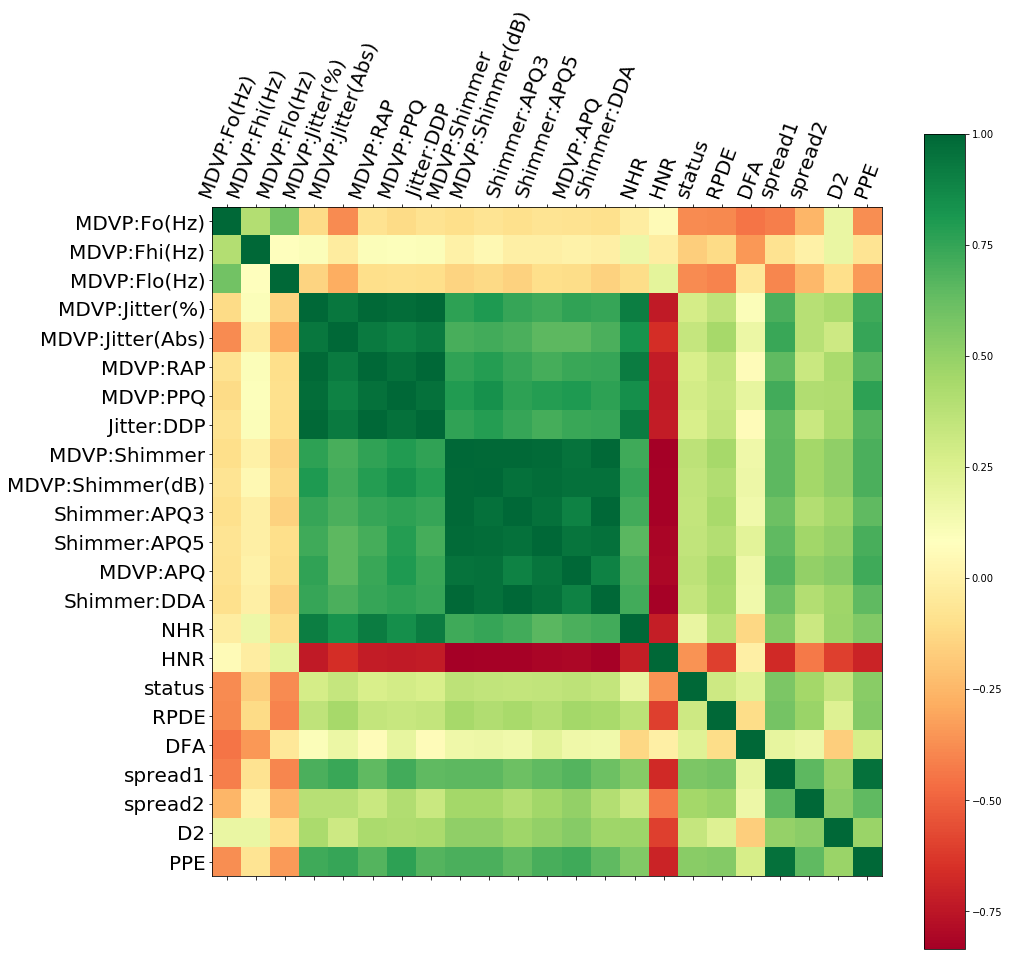

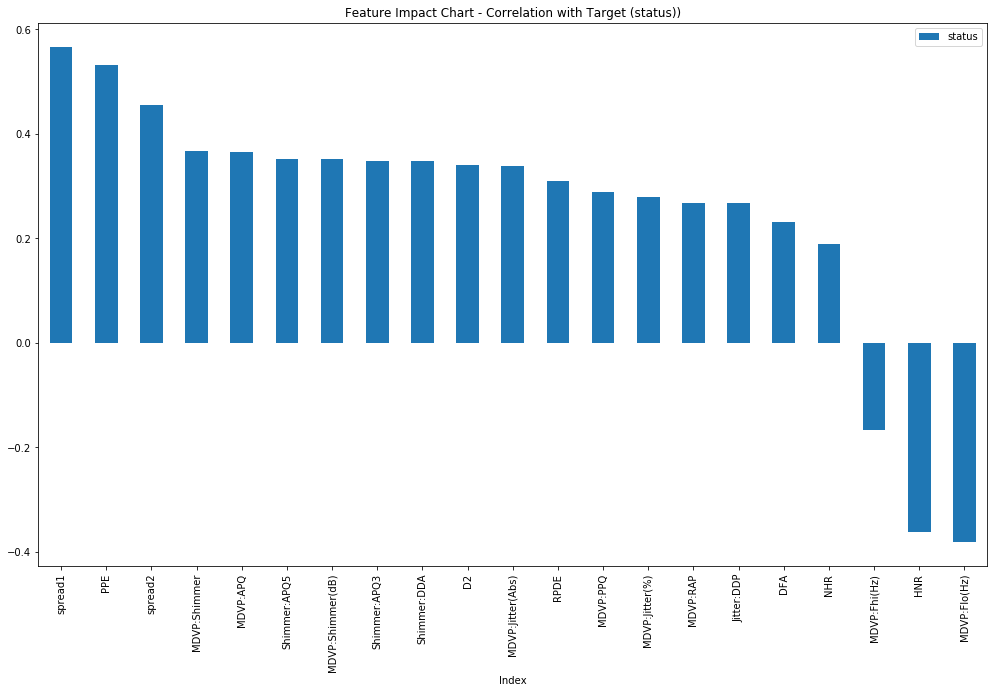

In [3]:
#  This function does the actual graphical plotting of the correlation matrix.  To see the actual correlation 
#  numbers, simply use this call: df_scaled.corr()

def plot_corr(df, size=15):
    corr = df.corr()
    #plt.rcParams["axes.grid"] = False  # gets rid of grid
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap=plt.cm.RdYlGn)
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=70)
    plt.yticks(range(len(corr.columns)), corr.columns)
    fig.colorbar(cax)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    fig.savefig('corr_mat.png', bbox_inches='tight')

#
#  Code below to generate Correlation Plots and Feature Impact Plots

# Correlation Plot
df_c = df.copy()
target = 'status' 
df_c.pop('name')
df_c = df_c.drop_duplicates().dropna()
plot_corr(df_c)

# Feature Impact Chart
df_new = df_c.corr().sort_values([target], ascending = False)
df_new.drop(df_new.head(1).index, inplace=True)
df_new.drop(df_new.tail(1).index, inplace=True)
df_new['Index'] = df_new.index
chart_title = ("Feature Impact Chart - Correlation with Target (%s))" % target)
df_new.plot(x='Index', y=target, kind='bar', 
            title=chart_title,figsize=(17,10))

## Prepare the DataFrame for Machine Learning

In [0]:
'''Prep the dataset we wish to apply the model to.  This can include activities like grabbing parameters
from the dataframe (like 'Name') that you don't wish to use in the training/test data.'''
def prep_dataframe(df, flag, target):
    Name = df.pop('name')
    if flag == 'predict':
        df = df.fillna(0)
        df[target] = 0
    elif (flag == 'train'):
        df = df.fillna(0)        
    Name.append(Name)
    return df, Name

## Split Data into Training and Test Sets
This function takes a dataframe, the size of the test set in percentage of the whole, a randomizing seed, and the target column number as arguments.
First we capture the target column to prevent it from being scaled by the scaler.
Then, we convert the data (X) into numpy arrays and scale.  There are three scalers that are effective for this work.  MaxAbsScaler is better with sparse data.
Finally, we use Python sklearn's train_test_split function to return X and y for training and X and y for test.

### Inbalanced Learning
Inside this function there is the option to use inbalance learning to increase the sample size by creating intelligent, synthetic datapoints.  This is a technique that is common when a dataset is unbalanced in favor of one class or if it's too small to yield consistent results.  In this case, I'm employing the Synthetic Minority Oversampling Technique (SMOTE) algorithm. 

To oversample using SMOTE, take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point.

In [0]:
def split_data(df, size, predict_flag, use_imblearn, target):
    ''' Split the data into training and testing sets.  Column headers below are custom for the "Douglas data set".
    NaN's are filled with zero to maintain consistent data shapes.
    
    INPUTS:
    
    df: dataframe we're passing in
    predict_flag: if we're just doing inference (and don't need to do a train/test split)
    use_imblearn: whether we want to use synthetic oversampling to address unbalanced datasets
    target: the column ID for the target feature
    
    RETURNS:
    
    X_train, X_test, y_train, y_test (for predict_flag = False)
    X, y (for predict_flag = True)
    
    '''
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing
    from imblearn.combine import SMOTEENN
    
    df = df.convert_objects(convert_numeric=True).fillna(0)
    
    y = df.pop(target)          # Remove the 'target' column that has the labels
    y = np.array(y).astype(int) # in case the target is a float for some reason
    X = df.fillna(0)
    X = np.array(X)
    
    '''
    Scale the data.  This allows many of the algorithms to work more effectively
    The MinMaxScaler scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

    The transformation is given by:

        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        X_scaled = X_std * (max - min) + min
    '''
    
    X = preprocessing.MinMaxScaler().fit_transform(X)

    
    if predict_flag:  # We're predicting y for new values of X, so no need to train and test
        return X, y
      
    else:
        #
        # Split the training and test datasets by 'size'.  Often 60% train, 40% test.
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=size) # Keeping the test set small to evaluate timing
        
        #
        # The SMOTE algorithm is Synthetic Minority Over-sampling Technique and it uses Edited Nearest Neighbors for optimal oversampling.
        #
        if use_imblearn:
            sm = SMOTEENN()
            X_train, y_train = sm.fit_sample(X_train, y_train) # This just oversamples the training set.  
        
        return X_train, X_test, y_train, y_test

## Confusion Matrix

Here's code to plot the confusion matrix, both in a raw and in a normalized fashion.

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=2)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.clim(0,1) # Reset the colorbar to reflect probabilities

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid('off')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def call_confusion_matrix(y_test, y_pred, target_array, filename, size=5):
    from sklearn.metrics import confusion_matrix
    #class_names = ['On-Time', 'Late']# Compute confusion matrix
    class_names = target_array
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    np.set_printoptions(precision=2)
    filename1 = ("1_%s" % filename)
    filename2 = ("2_%s" % filename)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(size, size), dpi=200)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    
    plt.savefig(filename1, bbox_inches='tight')

    # Plot normalized confusion matrix
    plt.figure(figsize=(size, size), dpi=200)

    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    
    plt.savefig(filename2, bbox_inches='tight')

    plt.show()


## CLASSIFICATION TECHNIQUES

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=1 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of ram. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization error can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

### Strategy to overcome unbalanced dataset

Since there are so many more players with less than the desired dollar value, the dataset is very unbalanced.  Generally, in these cases, the confusion matrix and classifier score looks bad for the less prevalent targets.  This means that the classification result (whether the probability is 50% or greater) is not really important.  To overcome this, I average the probabilities for each record over ten iterations.  This probability number is then what I use to identify players with potential of being a high dollar player.  When coupled with something like average draft position or average auction value next spring, one can identify values (low auction value coupled with higher probability of value).



In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hinge_loss
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve
from sklearn import linear_model

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


def classify_predict(filename_train, target, model, use_imblearn, out_filename):

    df = pd.read_csv(filename_train, parse_dates=True)
    
    class_names = [ 'Healthy Patient', 'Parkinsons']
    
    '''
    Now process the training data set.
    '''
    df_train, Name = prep_dataframe(df, 'train', target)

    # Split data: 40% of data goes into the test set, Use target 13 (4wk CPI prediction)
    X_train, X_test, y_train, y_test = split_data(df_train, 0.30, False, use_imblearn, target) # Predict_flag = False

    print ("Model hyperparameters:")

    print(model) # Captures the various hyperparameters of the model
    
    #cross_val_NN(model, X_train, y_train)  # Here's how we do cross_validation for the MLP NN
    #cross_val_RF(model, X_train, y_train)

    ck_array = []
    
    # Fit the model below, then predict values for the test dataset.
    
    model.fit(X_train, y_train)
    predicted = model.predict(X_test) # These are the Targets we predict (to compare to the expected values later)
    prob_in_class = model.predict_proba(X_test)
    ck_score = cohen_kappa_score(y_test, predicted)

    expected = y_test # This is the values of the Target that we 'know' from the historical data
    
    # summarize the fit of the model

    print("Report that scores the ability of the model to predict the target on the test data:\n")
    print(metrics.classification_report(expected, predicted))
    print ()
    print(" * Precision Score = total positive results / sum(total positives, false positives)")
    print("          The precision is intuitively the ability of the classifier not to label as") 
    print("          positive a sample that is negative.")
    print
    print(" * Recall Score = total postivies / sum(total positives, false negatives)")
    print("          The recall score is intuitively the ability of the classifier to find all") 
    print("          the positive samples.")
    print
    print(" * F1-Score = (precision * recall)/(precision + recall)")
    print("          The F1 score can be interpreted as a weighted average of the precision and") 
    print("          recall")
    print ()
    print("CONFUSION MATRIX")
    """
    Below is the work to plot out graphical confusion matricies. It plots CM's for both raw counts 
    as well as normalized values. This is useful as it allows the analyst to understand how well the 
    model is predicting (and mis-predicting) the results.
    """
    print(call_confusion_matrix(expected, predicted, class_names, 'parkinsons_confusion_matrix.png', 5))
    score =  model.score(X_test, y_test)
    print ("Overall Score is: %8.2f" % score)
    print ("______________________________________________________________________________________")
    print

    print("Cohen's Kappa Score compares estimator performance with a random baseline estimator.")
    print("Avg. Cohen-Kappa Score %8.2f\n" % ck_score)
    
    # Uncomment the below if you have new X measurements to predict.  This is not the case for this example.
    
    ''' 
    Predict future results
    _____________________________________________________________________________________
    

    df_pred, Name = prep_dataframe(df_predict, 'predict', 'classification', target)

    X_predict, y_bogus = split_data(df_pred, 0, True, use_imblearn, target) # Predict_flag = True

    predict_val = model.predict(X_predict)
    probs = model.predict_proba(X_predict)[:,1]


    df_pred = pd.DataFrame()

    df_pred['Name'] = Name
    df_pred['Predicted Value'] = predict_val
    df_pred['Probs'] = probs

    df_pred.to_csv(out_filename)

    print (df_pred.sort_values(['Predicted Value','Probs'], ascending=[False,False]))
    
    '''

## Main Routine

Here we pick our models and call classify_predict()

There are a number of models that can be selected.  Simply replace the model passed to the 'classifier' variable.  Below I have implemented:
* A Restricted Boltzmann machine pipeline (with a logistic regression classifier)
* A Logistic Regression Classifier with built-in Cross Validation
* A Random Forest Classifier
* A Multi-Layer Perceptron Classifier
* A Linear Discriminant Analysis Classifier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Model hyperparameters:
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=81,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Report that scores the ability of the model to predict the target on the test data:

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.93      0.89      0.91        44

    accuracy                           0.86        59
   macro avg       0.82      0.84      0.83        59
weighted avg       0.87      0.86      0.87        59


 * Precision Score = total positive results / sum(total positives, false posit

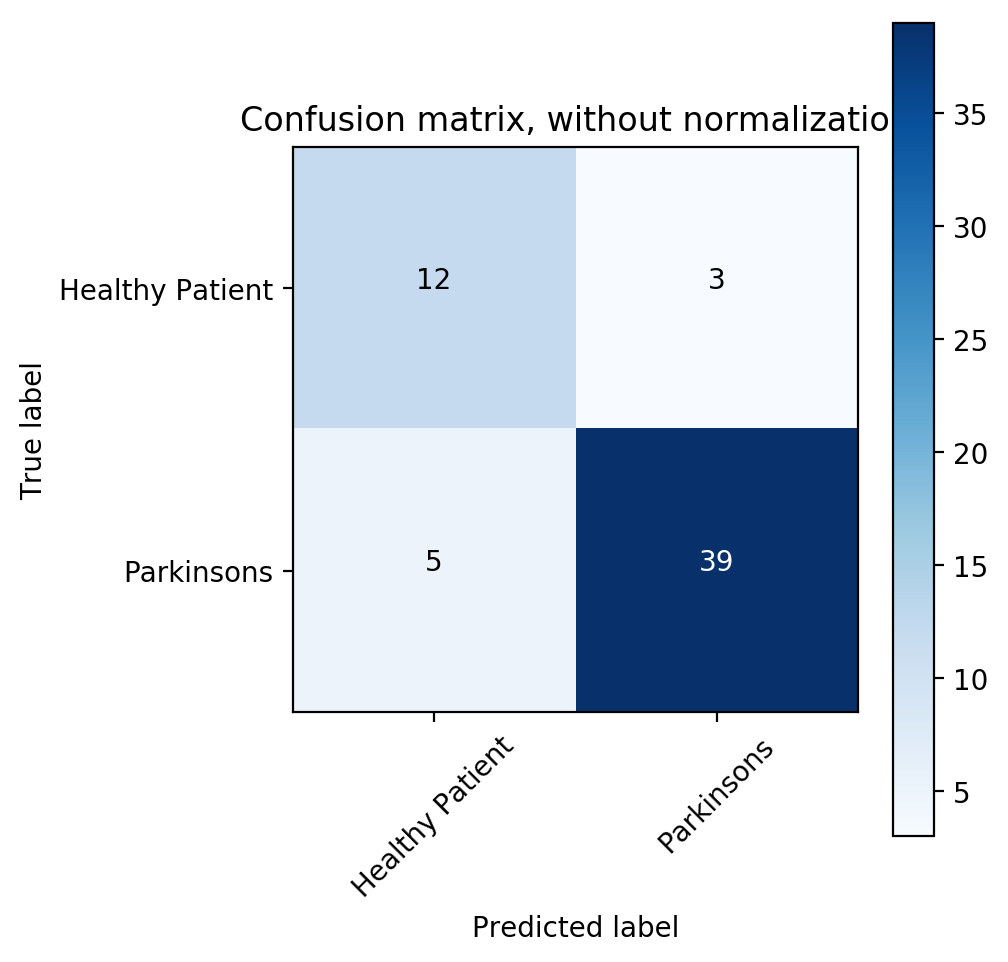

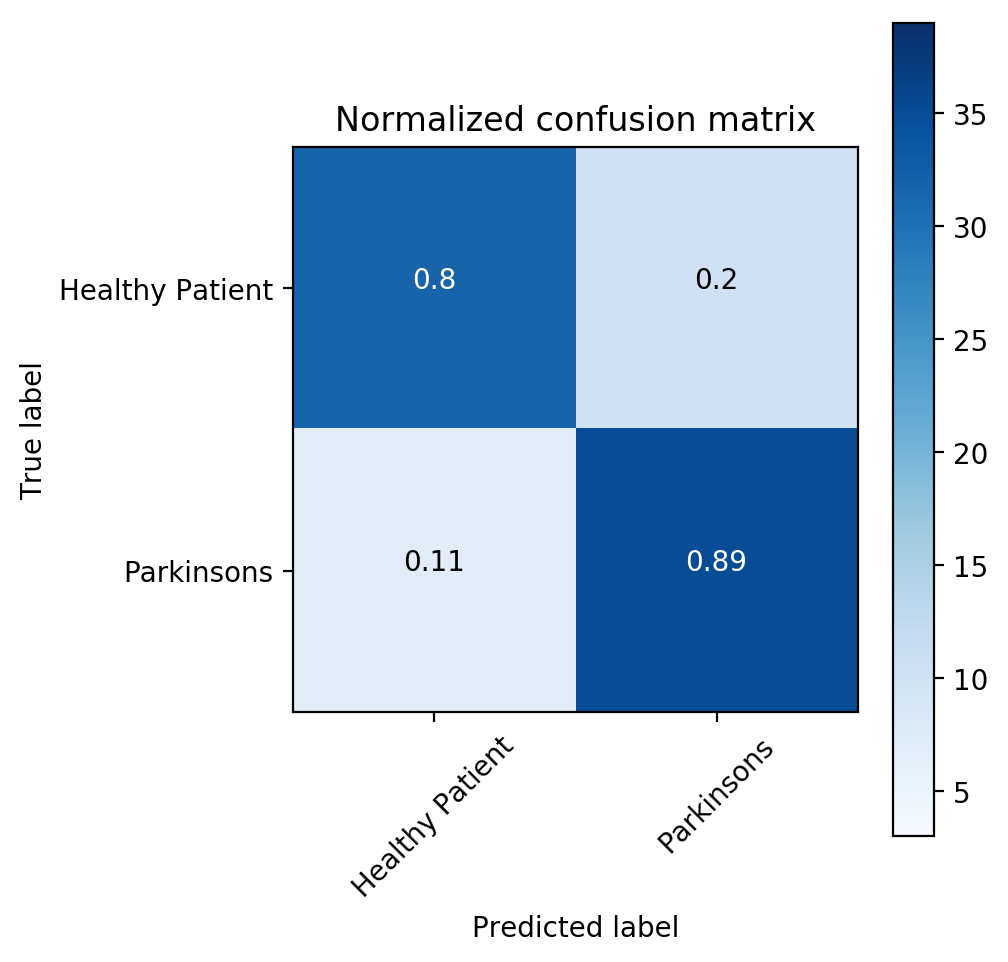

None
Overall Score is:     0.86
______________________________________________________________________________________
Cohen's Kappa Score compares estimator performance with a random baseline estimator.
Avg. Cohen-Kappa Score     0.66



In [11]:
#  Main routine.  Feel free to switch models or test new models by passing to the classifier variable.

#
#  Flag to determine if we use the SMOTE algorithm to do synthetic oversampling.  Addresses unbalanced data.
#
use_imblearn = False

out_filename = 'parkinsons_out.csv' # output file with predictions

#  Logistic Regression with Cross-Validation
logisticcv = linear_model.LogisticRegressionCV(class_weight='balanced', scoring='roc_auc', n_jobs=-1, max_iter=10000, verbose=1)

#  Random Forest
model_rf = RandomForestClassifier(n_estimators=81, criterion='gini', bootstrap=False, min_samples_leaf = 4, 
                              min_samples_split = 8, max_features = 8, max_depth = None)

#  Multi-layer Perceptron (neural net)
model_nn= MLPClassifier(solver='adam', alpha=1e-5, shuffle=True, hidden_layer_sizes=(100,80,3))

#  LDA Model
model_lda = LDA(n_components=3)

classifier = model_rf  # feel free to switch models around

classify_predict(filename, target, classifier, use_imblearn, out_filename)

## Support Libraries Below

* Cross-Validation Calls (to optimize hyperparameters)
* Confusion Matrix Calls

It's smarter to put these in a library and then call them from the library, but for the sake of simplicity (avoiding Google authentication), I'm incorporating everything in the workbook.

In [0]:
from scipy import stats

#  This is the reporting function for cross-validation

import operator 
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=operator.itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
def cross_val_RF(model, X, y):
    
    rs = RandomizedSearchCV(model,  param_distributions={
        'n_estimators': stats.randint(30, 200),
        'max_features': ['auto', 'sqrt', 'log2'],
        "max_depth": [3, None],
        "max_features": stats.randint(1, 11),
        "min_samples_split": stats.randint(1, 11),
        "min_samples_leaf": stats.randint(1, 11),
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]})

    rs.fit(X, y)
    
    report(rs.grid_scores_)  
    
def cross_val_NN(model, X, y):
    rs = RandomizedSearchCV(model, scoring='f1', param_distributions={
        'learning_rate': stats.uniform(0.001, 0.05),
        'hidden0__units': stats.randint(10, 200),
        'hidden1__units': stats.randint(20, 200),
        'hidden2__units': stats.randint(4, 100),
        'hidden3__units': stats.randint(4, 50),
        'hidden4__units': stats.randint(4, 50),
        'hidden0__type': ["Rectifier", "Sigmoid", "Tanh"],
        'hidden1__type': ["Rectifier", "Sigmoid", "Tanh"],
        'hidden2__type': ["Rectifier", "Sigmoid", "Tanh"],
        'hidden3__type': ["Rectifier", "Sigmoid", "Tanh"],
        'hidden4__type': ["Rectifier", "Sigmoid", "Tanh"]})

    rs.fit(X, y)
    
    report(rs.grid_scores_)
    
def cross_val_RBM(model, X, y):
    rs = RandomizedSearchCV(model, param_distributions={
            'n_components': stats.randint(1, 256),
            'learning_rate': stats.uniform(0.001, 0.05),
            'batch_size': stats.randint(1, 10),},
                           scoring='')
    rs.fit(X, y)
    
    report(rs.grid_scores_) 

In [0]:
def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_splits=3):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores
